In [2]:

!pip install pandas scikit-learn imbalanced-learn matplotlib seaborn



In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import time
import warnings
import joblib
import plotly.express as px

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [5]:
# Load the dataset
file_path = '/content/human_vital_signs_dataset_2024.csv'
data = pd.read_csv(file_path)

# Display dataset info
print("Dataset Overview:")
print(f"Shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())
print("\nData Statistics:")
print(data.describe())
print("\nRisk Category Distribution:")
print(data['Risk Category'].value_counts())

# Data Preprocessing
print("\nPreprocessing data...")

# Convert timestamp to datetime and extract features
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['DayPart'] = pd.cut(data['Hour'],
                         bins=[0, 6, 12, 18, 24],
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                         include_lowest=True)

# Encode categorical variables
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
data['RiskBinary'] = data['Risk Category'].map({'Low Risk': 0, 'High Risk': 1})



Dataset Overview:
Shape: (16313, 17)

First 5 rows:
   Patient ID  Heart Rate  Respiratory Rate                   Timestamp  \
0           1          60                12  2024-07-19 21:53:45.729841   
1           2          63                18  2024-07-19 21:52:45.729841   
2           3          63                15  2024-07-19 21:51:45.729841   
3           4          99                16  2024-07-19 21:50:45.729841   
4           5          69                16  2024-07-19 21:49:45.729841   

   Body Temperature  Oxygen Saturation  Systolic Blood Pressure  \
0         36.861707          95.702046                    124.0   
1         36.511633          96.689413                    126.0   
2         37.052049          98.508265                    131.0   
3         36.654748          95.011801                    118.0   
4         36.975098          98.623792                    138.0   

   Diastolic Blood Pressure   Age  Gender  Weight (kg)  Height (m)  \
0                      8

In [6]:
# Feature selection
features = ['Heart Rate', 'Respiratory Rate', 'Body Temperature',
            'Oxygen Saturation', 'Systolic Blood Pressure',
            'Diastolic Blood Pressure', 'Age', 'Gender', 'Weight (kg)',
            'Height (m)', 'Derived_HRV', 'Derived_Pulse_Pressure',
            'Derived_BMI', 'Derived_MAP', 'Hour']
target = 'RiskBinary'

X = data[features]
y = data[target]

# Drop rows with NaN values in the target variable
nan_indices = y[y.isna()].index
X = X.drop(nan_indices)
y = y.drop(nan_indices)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

print("Data splitting complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data splitting complete.
X_train shape: (13740, 15)
X_test shape: (3436, 15)
y_train shape: (13740,)
y_test shape: (3436,)


In [8]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling complete.")


Feature scaling complete.


In [9]:
# Train a RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

start_time = time.time()
model.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"\nModel training complete in {end_time - start_time:.2f} seconds.")


Model training complete in 1.71 seconds.


In [10]:
# Evaluate the model
y_pred = model.predict(X_test_scaled)

print("\nModel Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1702
         1.0       1.00      1.00      1.00      1734

    accuracy                           1.00      3436
   macro avg       1.00      1.00      1.00      3436
weighted avg       1.00      1.00      1.00      3436


Confusion Matrix:
[[1702    0]
 [   0 1734]]

Accuracy Score:
1.0


In [11]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Use StratifiedKFold to maintain the proportion of the target variable in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate cross-validation scores
cv_scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='accuracy', n_jobs=-1)

print("\nCross-validation Accuracy Scores:")
print(cv_scores)
print(f"\nMean Cross-validation Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of Cross-validation Accuracy: {cv_scores.std():.4f}")


Cross-validation Accuracy Scores:
[1. 1. 1. 1. 1.]

Mean Cross-validation Accuracy: 1.0000
Standard Deviation of Cross-validation Accuracy: 0.0000


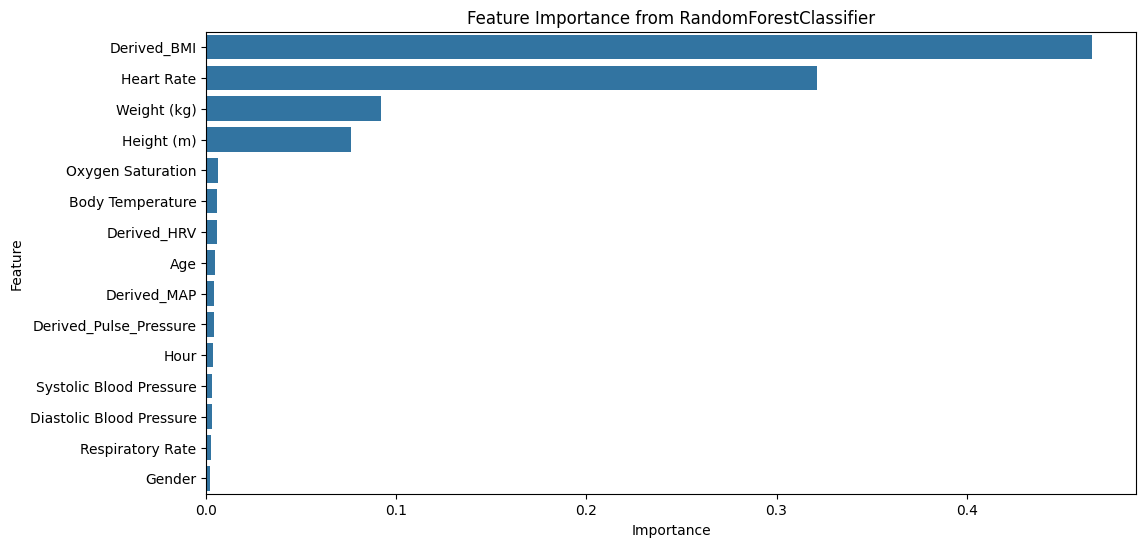

In [12]:
# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=features)

# Sort importances
sorted_importances = feature_importances.sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.title('Feature Importance from RandomForestClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

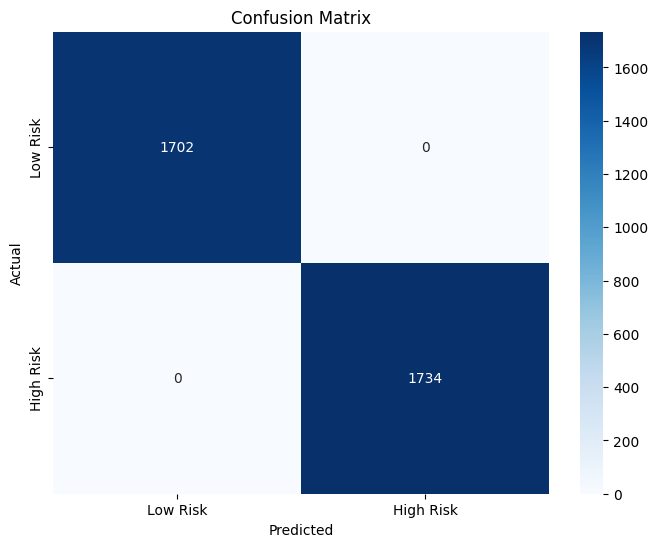

In [13]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Low Risk', 'High Risk'])
plt.yticks([0.5, 1.5], ['Low Risk', 'High Risk'])
plt.show()

In [14]:
joblib.dump(model, "wearsenseai_model_v2.pkl")
joblib.dump(scaler, "wearsenseai_scaler_v2.pkl")
print("\nModel saved as wearsenseai_model_v2.pkl")


Model saved as wearsenseai_model_v2.pkl


In [15]:
print("\n=== Starting Real-Time Monitoring Simulation ===")
high_risk_patients = []



=== Starting Real-Time Monitoring Simulation ===


In [16]:
def check_vitals(row):
    alerts = []
    # Vital signs alerts
    if row['Heart Rate'] > 100 or row['Heart Rate'] < 60:
        alerts.append("Heart Rate (abnormal)")
    if row['Respiratory Rate'] > 20 or row['Respiratory Rate'] < 12:
        alerts.append("Respiratory Rate (abnormal)")
    if row['Oxygen Saturation'] < 95:
        alerts.append("SpO2 (low)")
    if row['Body Temperature'] > 37.5 or row['Body Temperature'] < 36.1:
        alerts.append("Temperature (abnormal)")

    # Other feature alerts (example thresholds - adjust as needed)
    if row['Systolic Blood Pressure'] > 140 or row['Systolic Blood Pressure'] < 90:
        alerts.append("Systolic BP (abnormal)")
    if row['Diastolic Blood Pressure'] > 90 or row['Diastolic Blood Pressure'] < 60:
        alerts.append("Diastolic BP (abnormal)")
    if row['Age'] > 75:
        alerts.append("Age (elderly)")
    if row['Weight (kg)'] > 100: # Example threshold
        alerts.append("Weight (high)")
    if row['Height (m)'] < 1.5: # Example threshold
        alerts.append("Height (low)")
    if row['Derived_HRV'] < 0.05: # Example threshold
        alerts.append("HRV (low)")
    if row['Derived_Pulse_Pressure'] > 60: # Example threshold
        alerts.append("Pulse Pressure (high)")
    if row['Derived_BMI'] > 30: # Example threshold
        alerts.append("BMI (high)")
    if row['Derived_MAP'] > 100 or row['Derived_MAP'] < 70: # Example threshold
        alerts.append("MAP (abnormal)")
    # Hour doesn't typically have an "alert" state in this context

    return alerts

for i, row in data.iterrows():
    try:
        row_input = row[features].values.reshape(1, -1)
        scaled_input = scaler.transform(row_input)
        prob = model.predict_proba(scaled_input)[0][1]
        risk_label = "High Risk" if prob > 0.65 else "Low Risk"
        alerts = check_vitals(row)

        summary = f"[{row['Timestamp']:%Y-%m-%d %H:%M:%S}] Patient {row['Patient ID']} ({row['Age']}yo): "
        summary += f"Risk={risk_label} (prob={prob:.2%})"
        if alerts:
            summary += " | ALERTS: " + ", ".join(alerts)
            high_risk_patients.append(row['Patient ID'])

        print(summary)
        time.sleep(0.05)
    except Exception:
        continue

print("\n=== Simulation Completed ===")
print(f"Total High-Risk Patients Detected: {len(set(high_risk_patients))}")

Streaming output truncated to the last 5000 lines.
[2024-07-12 01:17:45] Patient 11317 (52.0yo): Risk=High Risk (prob=100.00%) | ALERTS: BMI (high)
[2024-07-12 01:16:45] Patient 11318 (87.0yo): Risk=High Risk (prob=98.00%) | ALERTS: Age (elderly), Pulse Pressure (high)
[2024-07-12 01:15:45] Patient 11319 (25.0yo): Risk=Low Risk (prob=8.00%) | ALERTS: Temperature (abnormal)
[2024-07-12 01:14:45] Patient 11320 (84.0yo): Risk=Low Risk (prob=1.00%) | ALERTS: Age (elderly)
[2024-07-12 01:13:45] Patient 11321 (27.0yo): Risk=Low Risk (prob=0.00%)
[2024-07-12 01:12:45] Patient 11322 (50.0yo): Risk=High Risk (prob=95.00%) | ALERTS: Pulse Pressure (high)
[2024-07-12 01:11:45] Patient 11323 (36.0yo): Risk=Low Risk (prob=1.00%)
[2024-07-12 01:10:45] Patient 11324 (57.0yo): Risk=Low Risk (prob=0.00%)
[2024-07-12 01:09:45] Patient 11325 (21.0yo): Risk=High Risk (prob=98.00%) | ALERTS: BMI (high)
[2024-07-12 01:08:45] Patient 11326 (87.0yo): Risk=High Risk (prob=97.00%) | ALERTS: Age (elderly)
[2024-


Enhanced Data Analysis:


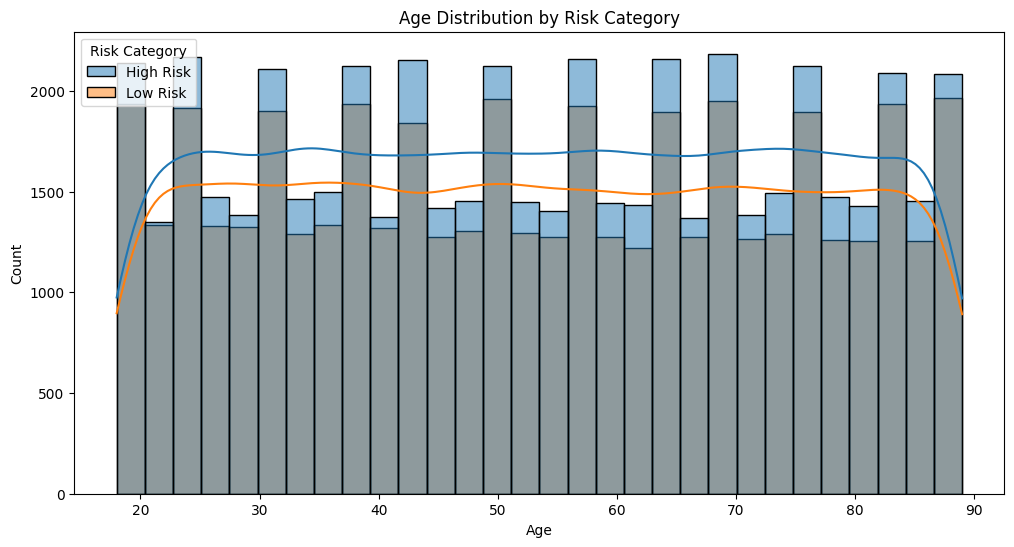

In [22]:
import plotly.express as px
from scipy import stats

# Enhanced EDA with Patient Distribution Plots
print("\nEnhanced Data Analysis:")

# Age distribution by risk category
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Age', hue='Risk Category', kde=True, bins=30)
plt.title('Age Distribution by Risk Category')
plt.savefig('age_distribution.png')
plt.show()


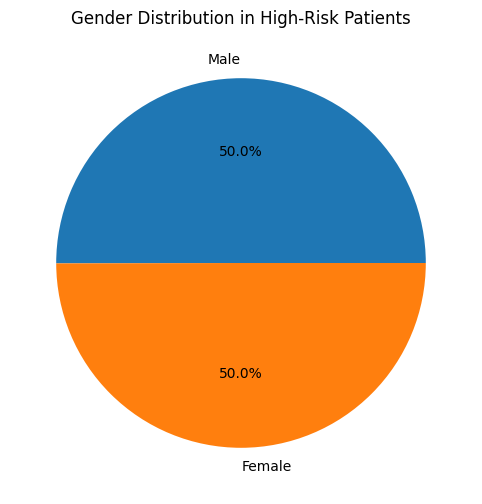

In [23]:
# Gender distribution in high-risk patients
gender_risk = data[data['Risk Category'] == 'High Risk']['Gender'].value_counts()
plt.figure(figsize=(8, 6))
gender_risk.plot(kind='pie', autopct='%1.1f%%', labels=['Male', 'Female'])
plt.title('Gender Distribution in High-Risk Patients')
plt.ylabel('')
plt.savefig('gender_distribution.png')
plt.show()



Post-Simulation Analysis:


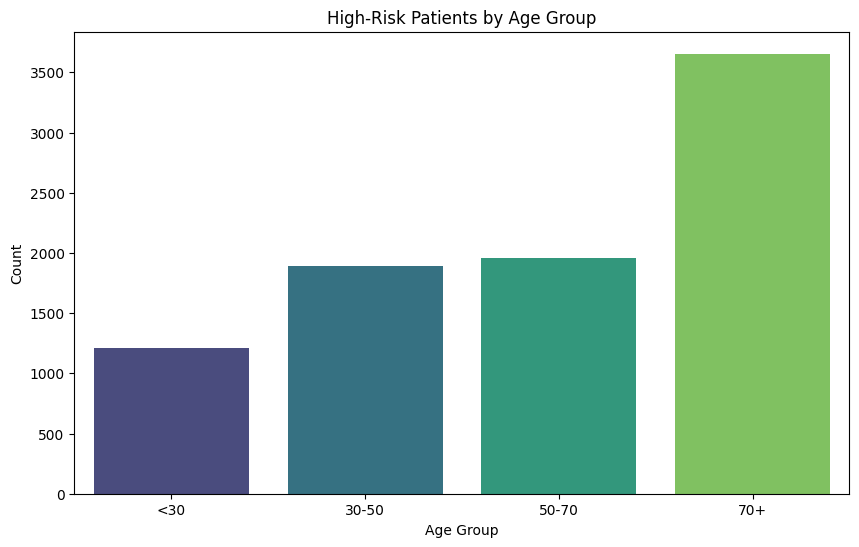

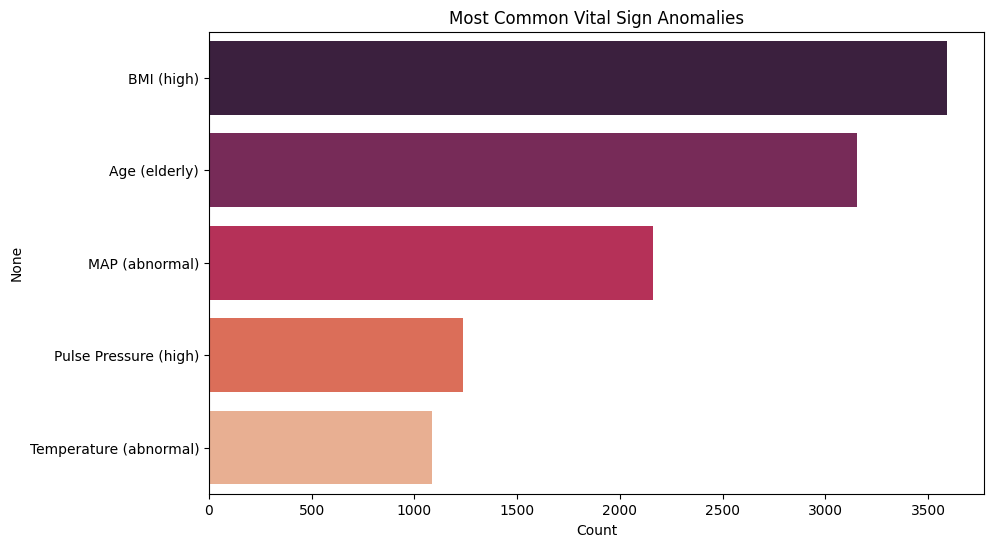

In [17]:
# Post-Simulation Analysis
print("\nPost-Simulation Analysis:")

# High-risk patients by age group
high_risk_data = data[data['Patient ID'].isin(high_risk_patients)]
high_risk_data['Age Group'] = pd.cut(high_risk_data['Age'],
                                     bins=[0, 30, 50, 70, 100],
                                     labels=['<30', '30-50', '50-70', '70+'])

plt.figure(figsize=(10, 6))
sns.countplot(x='Age Group', data=high_risk_data, palette='viridis')
plt.title('High-Risk Patients by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.savefig('high_risk_age_groups.png')
plt.show()

# Most common vital sign anomalies
alert_counts = {}

for i, row in data.iterrows():
    alerts = check_vitals(row)
    for alert in alerts:
        if alert in alert_counts:
            alert_counts[alert] += 1
        else:
            alert_counts[alert] = 1

# Convert to a pandas Series for easy plotting
alert_counts_series = pd.Series(alert_counts).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=alert_counts_series.values, y=alert_counts_series.index, palette='rocket')
plt.title('Most Common Vital Sign Anomalies')
plt.xlabel('Count')
plt.savefig('common_anomalies.png')
plt.show()

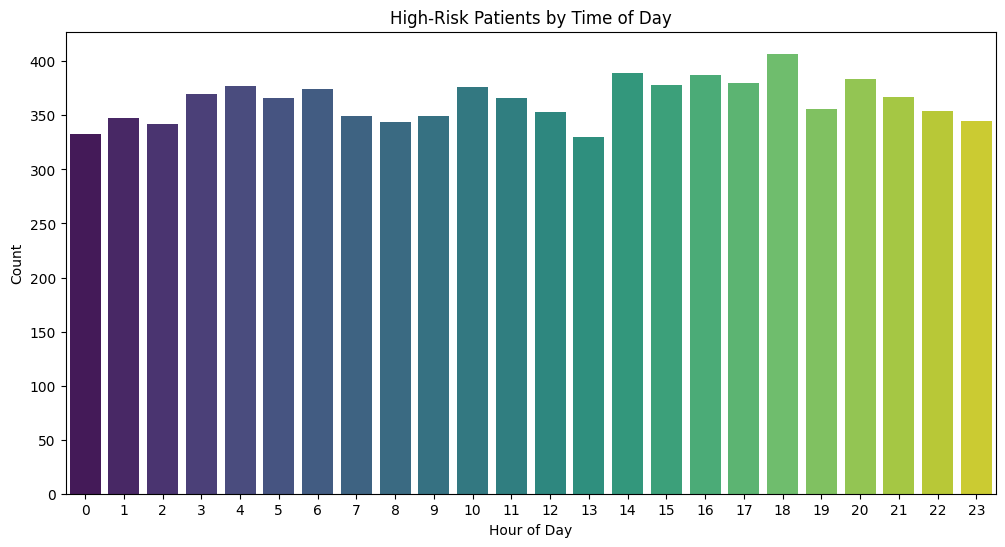

In [20]:
# Temporal patterns in high-risk patients
high_risk_data['Hour'] = high_risk_data['Timestamp'].dt.hour
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=high_risk_data, palette='viridis')
plt.title('High-Risk Patients by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.savefig('temporal_patterns.png')
plt.show()

# Interactive 3D plot of vital signs (requires plotly)
fig = px.scatter_3d(high_risk_data.head(2000),
                    x='Heart Rate',
                    y='Oxygen Saturation',
                    z='Body Temperature',
                    color='Age',
                    size='Systolic Blood Pressure',
                    hover_data=['Patient ID', 'Age'],
                    title='Vital Signs of High-Risk Patients')
fig.write_html("vital_signs_3d.html")
fig.show()
